Drowsiness Detection Model: Description: In this task, you will train a machine learning model to detect whether a person is asleep or awake in a vehicle. The model should be capable of detecting multiple people in a single image or video, identifying how many people are present, and determining how many are sleeping. If someone is detected as sleeping, the model should mark them in red and also predict their age. You can also show a pop-up message saying the numbers of sleeping people and their age. Guidelines: You should have a proper GUI with features for both image and video. Should have a preview of the input image or video. Don’t forget to add the pop-up message.


## Driver Drowsiness Detection Model

## Import Modules

In [6]:
import os 
import cv2
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import face_recognition
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')

## highlight facial points in the image

In [7]:
image_path="C:/Users/hp/Documents/null_class/null_class_project1/drowsiness_detection/WhatsApp Image 2025-03-10 at 19.41.38_d9c8f85f.jpg"

(-0.5, 898.5, 1598.5, -0.5)

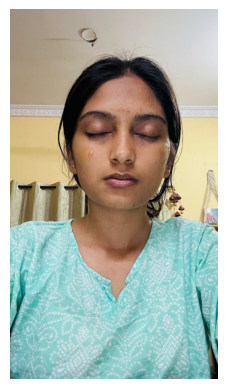

In [8]:
image= Image.open(image_path)
plt.imshow(image)
plt.axis('off')


In [11]:
def highlight_facial_points(image_path):
    image_bgr=cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image_rgb, model='cnn')
    for face_location in face_locations:
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        # Iterate over the facial landmarks and draw them on the image
        for landmark_type, landmark_points in landmarks.items():
            for (x, y) in landmark_points:
                cv2.circle(image_rgb, (x, y), 3, (0, 255, 0), -1)

    plt.figure(figsize=(6,6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

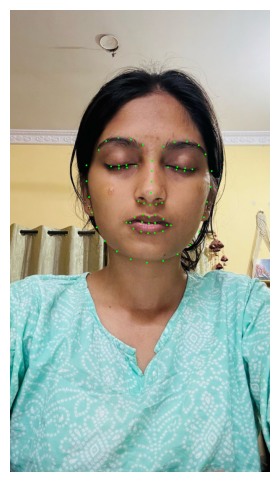

In [12]:
highlight_facial_points(image_path)

In [20]:
# calculate eye aspect ratio
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A+B) / (2.0 * C)
    return ear

# calculate mount aspect ratio
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A+B) / (2.0 * C)
    return mar

In [21]:
def process_image(frame):
    # define thresholds
    EYE_AR_THRESH = 0.25
    MOUTH_AR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image is not found or unable to open')

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # find all face locations
    face_locations = face_recognition.face_locations(rgb_frame)

    # initiate flags
    eye_flag = mouth_flag = False

    for face_location in face_locations:
        # extract facial landmarks
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        # extract eye and mouth coordinates
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])

        # calculate ear and mar
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear+right_ear) / 2.0
        mar = mouth_aspect_ratio(mouth)

        # check if eyes are closed
        if ear < EYE_AR_THRESH:
            eye_flag = True

        # check if yawning
        if mar > MOUTH_AR_THRESH:
            mouth_flag = True

    return eye_flag, mouth_flag

In [24]:
img = cv2.imread(image_path)
process_image(img)

(True, False)

In [27]:
video_path = "C:/Users/hp/Pictures/Camera Roll/WIN_20250310_23_02_08_Pro.mp4"
# video_cap = cv2.VideoCapture(0) # for getting frames from the webcam
video_cap = cv2.VideoCapture(video_path)
count = score = 0

while True:
    success, image = video_cap.read()
    if not success:
        break

    image = cv2.resize(image, (800, 500))

    count += 1
    # process every nth frame
    n = 5
    if count % n == 0:
        eye_flag, mouth_flag = process_image(image)
        # if any flag is true, increment the score
        if eye_flag or mouth_flag:
            score += 1
        else:
            score -= 1
            if score < 0:
                score = 0

    # write the score values at bottom left of the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_x = 10
    text_y = image.shape[0] - 10
    text = f"Score: {score}"
    cv2.putText(image, text, (text_x, text_y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    if score >= 5:
        text_x = image.shape[1] - 130
        text_y = 40
        text = "Drowsy"
        cv2.putText(image, text, (text_x, text_y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow('drowsiness detection', image)

    # exit if any key is pressed
    if cv2.waitKey(1) & 0xFF != 255:
        break

video_cap.release()
cv2.destroyAllWindows()
 